In [481]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [482]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

## Краткое описание курсового проекта

### Цель курсового проекта

**Проанализировать данные о продажах и остатках компании.**
* Сделать краткую сводку о структуре продаж.
* Показать основные валовые показатели компании в динамике.
* Провести ABC-анализ по товарным группам, показать распределение продаж.

**Провести статистический анализ данных**  
* Рассчитать основные статистические показатели по компании, товарным группам и товарам.
* Проверить продажи на нормальное распределение. Показать различные варианты их распределения на графиках.
* Провести корректировку и очистку "плохих" данных. Дополнить данные продажами в периоды отсутствия товара на складах, скорректировать резкие выбросы и т.д.
* На основании фактических и очищенных данных построить прогноз продаж для каждого товара, товарной группы и компании в целом на следующий сквозной год (октябрь 2020 - сентябрь 2021). 
* Для этого использовать в качестве основной модели - линейную регрессию, совместно с коэффициентами сезонности.
* Результаты прогноза представить на графиках и в таблицах.

**Сделать общие выводы и провести оценку полученной модели**

### Описание данных

**Основной датасет**

Данные о продажах компании за скользящие 2 года по месяцам (детализация до отдельных товаров)
Период данных - октябрь 2018 - сентябрь 2020

Товарные аналитические признаки:
* Бренд
* Категория товара
* Товарная группа
* Модель
* Артикул
* Статус товара - его жизненный цикл (Новый, Действует, Отменен)

Временные признаки:
* Год
* Месяц
* Номер периода и т.д.

Показатели в исходном датасете:
* Количество продано (штуки)
* Оборот (руб)
* Себестоимость проданного товара (руб)
* Средний товарный запас (штуки)
* Средний товарный запас (руб)

**Вспомогательные датасеты**

* Данные с сезонными индексами по товарным группам (собраны с Яндекс Wordstat)
* Таблица - календарь по месяцам за три года. Два года фактических (как в основном датасете) и будущий год, тоже скользящий, октябрь 2020 - сентябрь 2021 (для построения плана)


In [483]:
# Исходные данные о продажах и остатках
df_data   = pd.read_excel('data_source_sales_and_balances.xlsx', sheet_name = 'Sales_and_Balances')

# Сезонные индексы по товарных группам (данные, собранные с Яндекс Wordstat)
df_season = pd.read_excel('data_source_sales_and_balances.xlsx', sheet_name = 'Season_Index')

# Периоды Факт - План
df_period = pd.read_excel('data_source_sales_and_balances.xlsx', sheet_name = 'Period')

## Исходные данные

In [484]:
df_data.shape, df_data.columns

((5739, 19),
 Index(['brand', 'product_category', 'product_group', 'model', 'articul',
        'status_purchase', 'yr', 'mn', 'yr_mn', 'period_id', 'yr_number',
        'cnt_days', 'ndays_outofstock', 'proc_instock', 'qnt_balance',
        'sm_balance', 'qnt_sale', 'sm_sale', 'sm_cost'],
       dtype='object'))

In [485]:
df_data.head(10)

,brand,product_category,product_group,model,articul,status_purchase,yr,mn,yr_mn,period_id,yr_number,cnt_days,ndays_outofstock,proc_instock,qnt_balance,sm_balance,qnt_sale,sm_sale,sm_cost
0,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2019,10,2019-10,13,2,8,1,0.875,88,464799,0,0,0
1,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2019,11,2019-11,14,2,30,0,1.000,51,307131,1,13512,7236
2,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2019,12,2019-12,15,2,31,0,1.000,63,373584,11,103453,71419
3,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2020,1,2020-01,16,2,31,0,1.000,88,525433,12,136964,86512
4,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2020,2,2020-02,17,2,29,0,1.000,81,490153,20,186363,128519
5,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2020,3,2020-03,18,2,31,0,1.000,75,514409,11,168622,89361
6,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2020,4,2020-04,19,2,30,0,1.000,72,511393,5,74160,41818
7,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2020,5,2020-05,20,2,31,0,1.000,68,462181,18,198533,136737
8,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2020,6,2020-06,21,2,30,0,1.000,57,362329,22,227026,152755
9,BORT,Бытовая техника,Измельчитель пищевых отходов,Alligator,93410754,ДЕЙСТВУЕТ,2020,7,2020-07,22,2,31,0,1.000,50,325924,23,251093,169078


### Общая описательная статистика

In [486]:
df_data.describe()

,articul,yr,mn,period_id,yr_number,cnt_days,ndays_outofstock,proc_instock,qnt_balance,sm_balance,qnt_sale,sm_sale,sm_cost
count,5.739000e+03,5739.000000,5739.000000,5739.000000,5739.00000,5739.000000,5739.000000,5739.000000,5739.000000,5.739000e+03,5739.000000,5.739000e+03,5.739000e+03
mean,9.375442e+07,2019.320788,6.451472,13.300924,1.55027,30.192717,5.555149,0.813922,236.439449,3.351934e+05,105.173027,2.338019e+05,1.593242e+05
std,2.826610e+06,0.641380,3.385977,6.786226,0.49751,2.465547,11.094003,0.366840,296.992304,3.899306e+05,162.993588,3.249707e+05,2.264112e+05
min,9.120447e+07,2018.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,-83.000000,-3.625020e+05,-2.236790e+05
25%,9.127404e+07,2019.000000,4.000000,8.000000,1.00000,30.000000,0.000000,1.000000,30.000000,5.344300e+04,11.000000,3.314850e+04,2.222300e+04
50%,9.341057e+07,2019.000000,6.000000,14.000000,2.00000,31.000000,0.000000,1.000000,144.000000,2.337760e+05,49.000000,1.284490e+05,8.576600e+04
75%,9.829000e+07,2020.000000,9.000000,19.000000,2.00000,31.000000,0.000000,1.000000,313.500000,4.747310e+05,129.000000,2.973540e+05,1.990365e+05
max,9.829995e+07,2020.000000,12.000000,24.000000,2.00000,31.000000,31.000000,1.000000,2329.000000,4.229266e+06,1753.000000,3.602375e+06,2.384005e+06


#### Для наглядности финансовые показатели из рублей перевожу в миллионы
* Стоимость остатка руб
* Оборот руб
* Себестоимость продаж руб

In [487]:
# Для наглядности показатели в рублях перевожу в миллионы (стоимость остатка, оборот и себестоимость продаж)

df_data['sm_balance'] = round(df_data['sm_balance'] / 10**6, 6)
df_data['sm_sale']    = round(df_data['sm_sale']    / 10**6, 6)
df_data['sm_cost']    = round(df_data['sm_cost']    / 10**6, 6)

# Ввожу новый показатель: Доход от продаж
df_data['sm_income']  = df_data['sm_sale'] - df_data['sm_cost']

# Модель товара - заглавные буквы
df_data['model'] = df_data['model'].str.upper()

### Основные показатели в динамике по месяцам за 2 года

* Количество продано (штуки)
* Оборот (млн руб)
* Себестоимость проданного товара (млн руб)
* Валовый доход (млн руб)
* Наценка (%)
* Маржа (%)
* Средняя цена продажи за единицу товара (руб)
* Средний остаток (руб)
* Уровень запаса, мес (упрощенная формула)

In [488]:
df_sales = df_data.groupby(['yr_number', 'yr', 'mn', 'yr_mn'], as_index = False).agg(
                                    {
                                        'qnt_sale':    'sum',
                                        'sm_sale':     'sum', 
                                        'sm_cost':     'sum', 
                                        'sm_income':   'sum',
                                        'sm_balance':  'sum'
                                    })
# Новые показатели: 
#   Средняя цена за ед; Наценка %; Маржа %
df_sales['price_avg']   = round(df_sales['sm_sale'] * 10**6 / df_sales['qnt_sale'], 0)
df_sales['proc_markup'] = round(df_sales['sm_income'] / df_sales['sm_cost'], 4) * 100
df_sales['proc_margin'] = round(df_sales['sm_income'] / df_sales['sm_sale'], 4) * 100

df_sales['stock_level'] = round(df_sales['sm_balance'] / df_sales['sm_cost'], 1)
df_sales

,yr_number,yr,mn,yr_mn,qnt_sale,sm_sale,sm_cost,sm_income,sm_balance,price_avg,proc_markup,proc_margin,stock_level
0,1,2018,10,2018-10,26776,48.543108,32.907650,15.635458,59.608936,1813.0,47.51,32.21,1.8
1,1,2018,11,2018-11,30303,53.094500,35.794798,17.299702,61.810947,1752.0,48.33,32.58,1.7
2,1,2018,12,2018-12,20194,37.721107,25.014620,12.706487,63.218203,1868.0,50.80,33.69,2.5
3,1,2019,1,2019-01,17690,33.142238,21.870493,11.271745,76.556122,1874.0,51.54,34.01,3.5
4,1,2019,2,2019-02,26575,50.660951,33.749619,16.911332,69.875516,1906.0,50.11,33.38,2.1
5,1,2019,3,2019-03,19942,37.592245,25.189568,12.402677,76.959620,1885.0,49.24,32.99,3.1
6,1,2019,4,2019-04,25285,52.646438,36.253263,16.393175,78.751788,2082.0,45.22,31.14,2.2
7,1,2019,5,2019-05,24233,51.390530,34.416401,16.974129,80.686373,2121.0,49.32,33.03,2.3
8,1,2019,6,2019-06,22894,47.199222,32.059242,15.139980,83.511455,2062.0,47.23,32.08,2.6
9,1,2019,7,2019-07,29634,61.565291,42.118607,19.446684,85.684663,2078.0,46.17,31.59,2.0


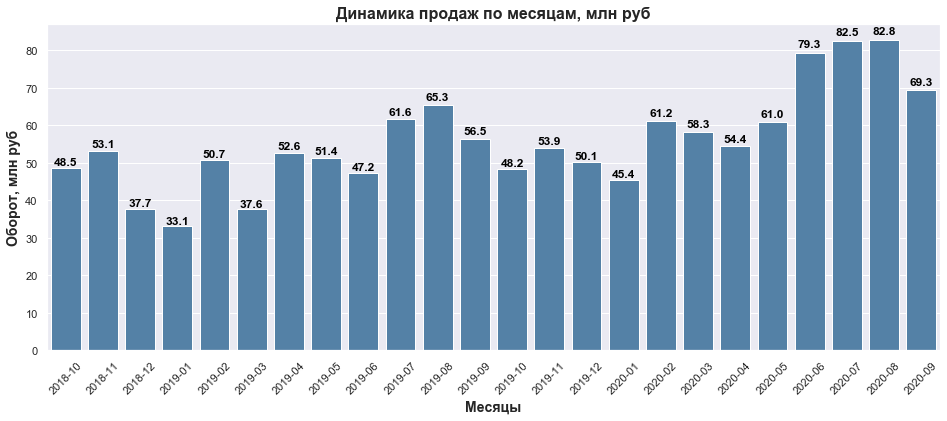

In [489]:
# Общая динамика продаж за 2 года по месяцам
sns.set()

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 6)

# g = sns.scatterplot(x='YrMn', y='Sm_Sale', data=df_sales, color = 'steelblue')
g = sns.barplot(x = 'yr_mn', y = 'sm_sale', data = df_sales, color = 'steelblue', ax = ax1 )

# ax2 = ax1.twinx()
# sns.scatterplot(x = 'yr_mn', y = 'proc_margin', data = df_sales, color = 'dark_red', ax = ax2)

plt.xticks(rotation = 45)

plt.title('Динамика продаж по месяцам, млн руб', fontsize = 16, weight = 'bold')
plt.xlabel('Месяцы',          fontsize = 14, weight = 'bold')
plt.ylabel('Оборот, млн руб', fontsize = 14, weight = 'bold')

for index, row in df_sales.iterrows():
    g.text(row.name, row.sm_sale + row.sm_sale * .02, round(row.sm_sale, 1), 
           color='black', ha="center", weight = 'bold', size = 12)

### Общие итоги за 2 года: 
* Месяцы (кол-во периодов, начало, конец)
* Кол-во уникальных Товарных групп, 
* Кол-во уникальных Товаров
* Годовой Оборот (за скользящий год)
* Среднемесячный Оборот

In [490]:
df_total = df_data.groupby(['yr_number']).agg({
                                                 'yr_mn':            ['nunique', 'min', 'max'],
                                                 'product_group':    ['nunique'], 
                                                 'model':            ['nunique'],
                                                 'sm_sale':          ['sum']
                                                })
df_total['sm_sale_per_month_avg', 'avg'] = 0
df_total = df_total.droplevel(1, axis=1)
df_total.columns = ['count_months', 'min_month', 'max_month', 
                    'count_product_groups', 'count_products', 
                    'sm_sale', 'sm_sale_per_month_avg']

df_total['sm_sale_per_month_avg'] = round(df_total['sm_sale'] / df_total['count_months'], 2)
df_total

,count_months,min_month,max_month,count_product_groups,count_products,sm_sale,sm_sale_per_month_avg
yr_number,,,,,,,
1,12,2018-10,2019-09,54,245,595.364384,49.61
2,12,2019-10,2020-09,56,273,746.424948,62.20


### Товарные группы - Общий оборот и количество уникальных моделей по группам и т.д.

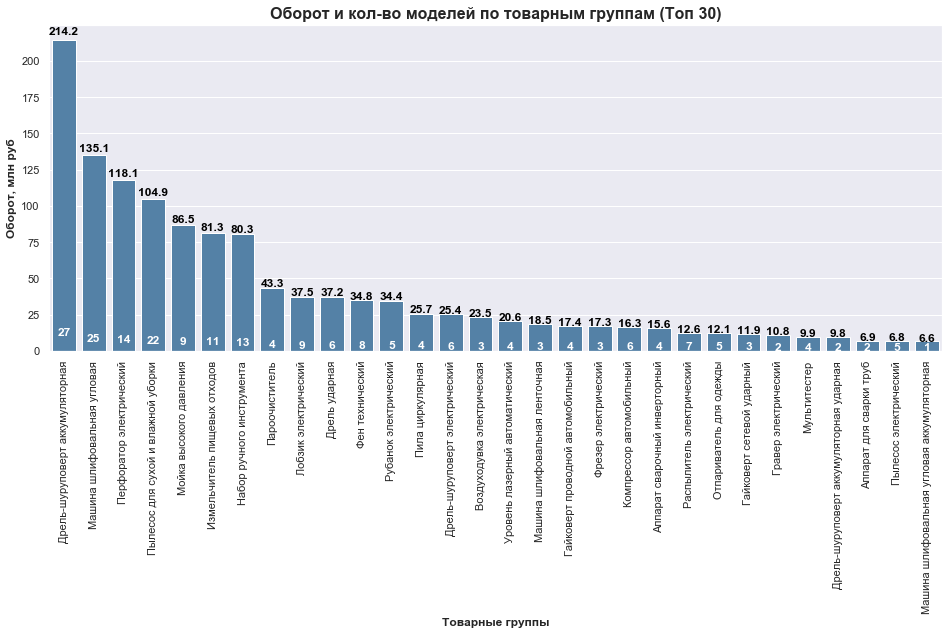

In [491]:
df_groups = pd.DataFrame(df_data.groupby(['product_group'], as_index = False).agg({
                                                                    'model':   'nunique',
                                                                    'sm_sale': 'sum'
                                                                }).sort_values(by = 'sm_sale', ascending = False))
df_groups.reset_index(inplace = True)

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

df_top_values = df_groups.head(30)
g = sns.barplot(x = 'product_group', y = 'sm_sale', data = df_top_values, color = 'steelblue')

plt.xticks(rotation = 90)

plt.title('Оборот и кол-во моделей по товарным группам (Топ 30)', fontsize = 16, weight = 'bold')
plt.xlabel('Товарные группы',  fontsize = 12, weight = 'bold')
plt.ylabel('Оборот, млн руб',  fontsize = 12, weight = 'bold')

for index, row in df_top_values.iterrows():
    g.text(row.name, row.sm_sale + row.sm_sale * .02, round(row.sm_sale, 1), 
           color = 'black', ha = "center", weight = 'bold', size = 12)
    
for index, row in df_top_values.iterrows():
    g.text(row.name, row.sm_sale * 0.05, round(row.model, 1), 
           color = 'white', ha = "center", weight = 'bold', size = 12)
plt.show()

### Товарные группы - Итоги продаж и статистика

In [492]:
df_groups_sales = df_data.groupby(['product_group', 'yr_number', 'yr', 'mn', 'yr_mn', 'period_id'], 
                                    as_index = False).agg({
                                                            'model':   'nunique',
                                                            'sm_sale': 'sum'
                                                        })
# df_groups_sales.reset_index(inplace = True)
# df_groups_sales = df_groups_sales.droplevel(1, axis=1)

df_groups_stat = df_groups_sales.groupby(['product_group'], as_index = False).agg(
                                                        { 
                                                            'yr_mn':   ['nunique'],
                                                            'model':   ['max'],
                                                            'sm_sale': ['sum', 'min', 'max', 'mean', 'median', 'std', 'var']
                                                        })
# df_groups_stat.reset_index(inplace = True)
# df_groups_stat = df_groups_stat.droplevel(0, axis=1)

df_groups_stat.columns = ['product_group', 'count_months', 'count_products', 
                              'sum', 'min', 'max', 'mean', 'median', 'std', 'var']
df_groups_stat = df_groups_stat.sort_values(by = 'sum', ascending = False)
df_groups_stat.head(30)

,product_group,count_months,count_products,sum,min,max,mean,median,std,var
12,Дрель-шуруповерт аккумуляторная,24,27,214.170946,5.048566,13.805815,8.923789,8.523993,2.440733,5.957177
24,Машина шлифовальная угловая,24,25,135.085568,2.660657,10.246789,5.628565,5.638184,2.209086,4.880061
36,Перфоратор электрический,24,14,118.061876,2.515169,8.588806,4.919245,4.386523,1.592855,2.537186
45,Пылесос для сухой и влажной уборки,24,22,104.875255,3.249647,5.619397,4.369802,4.266474,0.689901,0.475964
26,Мойка высокого давления,24,9,86.513958,0.628954,11.113526,3.604748,2.537720,2.961896,8.772829
15,Измельчитель пищевых отходов,24,11,81.279589,0.362294,7.643491,3.386650,3.636240,2.121264,4.499762
31,Набор ручного инструмента,24,13,80.338676,0.641461,8.256657,3.347445,3.372268,1.665218,2.772950
34,Пароочиститель,24,4,43.333706,0.000000,7.814066,1.805571,1.353554,1.807297,3.266322
18,Лобзик электрический,24,9,37.482531,0.704506,2.902431,1.561772,1.546593,0.470675,0.221535
9,Дрель ударная,24,6,37.223536,0.954430,2.414681,1.550981,1.501368,0.390153,0.152220


## ABC по товарным группам (по показателю Оборот)

In [493]:
df_groups_stat['sm_total']        = df_groups_stat['sum'].sum()
df_groups_stat['share_sale']      = df_groups_stat['sum'] / df_groups_stat['sm_total']
df_groups_stat['share_sale_cumm'] = 0
df_groups_stat['rank_abc'] = ''

count = df_groups_stat.shape[0]
i = 0
for index, row in df_groups_stat.iterrows():
    i += 1
    value = df_groups_stat.iloc[0:i]['share_sale'].sum()

    df_groups_stat.loc[index, 'share_sale_cumm'] = value
   
    if value <= 0.5:
        df_groups_stat.loc[index, 'rank_abc'] = 'A'
    elif value < 0.9:
        df_groups_stat.loc[index, 'rank_abc'] = 'B'
    else:
        df_groups_stat.loc[index, 'rank_abc'] = 'C'

# классификация ABC по товарным группам
df_groups_stat[['product_group', 'sum', 'share_sale', 'share_sale_cumm', 'rank_abc']]

,product_group,sum,share_sale,share_sale_cumm,rank_abc
12,Дрель-шуруповерт аккумуляторная,214.170946,0.159616,0.159616,A
24,Машина шлифовальная угловая,135.085568,0.100676,0.260292,A
36,Перфоратор электрический,118.061876,0.087988,0.348280,A
45,Пылесос для сухой и влажной уборки,104.875255,0.078161,0.426441,A
26,Мойка высокого давления,86.513958,0.064477,0.490917,A
15,Измельчитель пищевых отходов,81.279589,0.060576,0.551493,B
31,Набор ручного инструмента,80.338676,0.059874,0.611367,B
34,Пароочиститель,43.333706,0.032295,0.643663,B
18,Лобзик электрический,37.482531,0.027935,0.671597,B
9,Дрель ударная,37.223536,0.027742,0.699339,B


### Итоги по рангам ABC

In [494]:
df_abc_sale = df_groups_stat.groupby('rank_abc').agg({'sum': ['sum'], 'product_group': ['count'], 'share_sale': 'sum'})
df_abc_sale.reset_index(inplace = True)
df_abc_sale = df_abc_sale.droplevel(1, axis=1)
df_abc_sale.columns = ['rank_abc', 'sm_sale', 'count_groups', 'share_sale']
df_abc_sale['share_groups'] = round(df_abc_sale['count_groups'] / df_abc_sale['count_groups'].sum(), 6)
df_abc_sale = df_abc_sale[['rank_abc', 'count_groups', 'share_groups', 'sm_sale', 'share_sale']]
df_abc_sale

,rank_abc,count_groups,share_groups,sm_sale,share_sale
0,A,5,0.089286,658.707603,0.490917
1,B,17,0.303571,541.801876,0.403791
2,C,34,0.607143,141.279853,0.105292


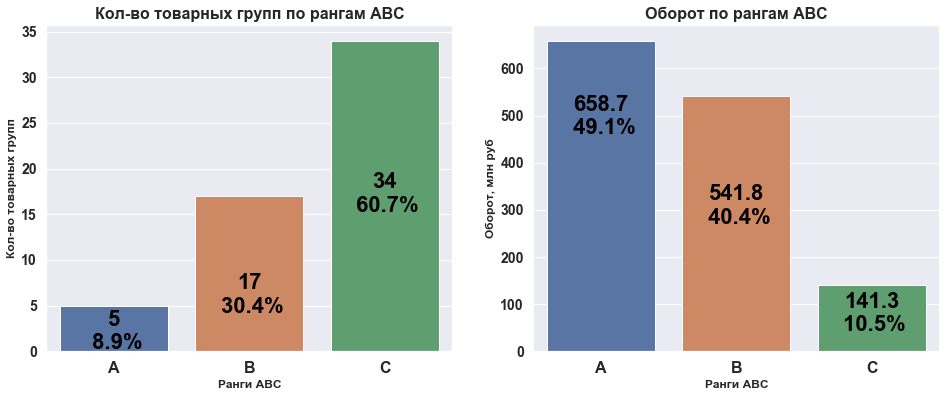

In [495]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

plt.subplot(121)
g1 = sns.barplot(x = 'rank_abc', y = 'count_groups', data = df_abc_sale)

plt.xlabel('Ранги ABC', fontsize = 12, weight = 'bold')
plt.ylabel('Кол-во товарных групп', fontsize = 12, weight = 'bold')
plt.title(f'Кол-во товарных групп по рангам ABC', fontsize = 16, weight = 'bold')

plt.xticks(fontsize = 16, weight = 'bold')
plt.yticks(fontsize = 14, weight = 'bold')

plt.subplot(122)
g2 = sns.barplot(x = 'rank_abc', y = 'sm_sale', data = df_abc_sale)

plt.xlabel('Ранги ABC', fontsize = 12, weight = 'bold')
plt.ylabel('Оборот, млн руб', fontsize = 12, weight = 'bold')
plt.title(f'Оборот по рангам ABC', fontsize = 16, weight = 'bold')

plt.xticks(fontsize = 16, weight = 'bold')
plt.yticks(fontsize = 14, weight = 'bold')

for index, row in df_abc_sale.iterrows():
    g1.text(row.name, row.count_groups * (0.05 + index * 0.2), str(round(row.count_groups, 0)) + \
                        '\n ' + str(round(row.share_groups * 100, 1)) + '%', 
               color = 'black', ha = "center", weight = 'bold', size = 22)

for index, row in df_abc_sale.iterrows():
    g2.text(row.name, row.sm_sale * (0.7 - index * 0.2), str(round(row.sm_sale, 1)) + \
                        '\n ' + str(round(row.share_sale * 100, 1)) + '%',
               color = 'black', ha = "center", weight = 'bold', size = 22)    
plt.show()

## Предобработка данных (корректировка и очистка данных)

### Общая статистика по товарам (sum, min, max, mean, median, std, var)

In [496]:
#--------------------------------------------------------------------------------------------------------
# Общая статистика по товарам  (sum, min, max, mean, median, std, var)
df_products_stat = df_data.groupby(['model']).agg({
                                                    'yr_mn':   ['nunique'],
                                                    'sm_sale': ['sum', 'min', 'max', 'mean', 'median', 'var', 'std']
                                                    }).reset_index()
df_products_stat.columns = ['model', 'count_months', 'sum', 'min', 'max', 'mean', 'median', 'var', 'std']

df_products_stat = df_products_stat.sort_values(by = 'sum', ascending = False)
df_products_stat.head(10)

#--------------------------------------------------------------------------------------------------------
# Объединяю исходные данные с общей статистикой
df_data['sm_sale_correct'] = df_data['sm_sale']
df_data['sm_sale_clean']   = 0

if not 'median' in df_data.columns:
    df_data = df_data.merge(df_products_stat, on = ['model'], how = 'left')

#--------------------------------------------------------------------------------------------------------
# Отмечаю значения, которые находятся внутри области (Среднее +/- 2*СКО)
df_data['count_in_std_2'] = 0
df_data.loc[ (df_data['sm_sale'] >= df_data['mean'] - 2 * df_data['std']) &
             (df_data['sm_sale'] <= df_data['mean'] + 2 * df_data['std']), 'count_in_std_2'] = 1

#--------------------------------------------------------------------------------------------------------
# В данных есть периоды, когда товара не было на остатке
# Для оценки наличия товара в каждом месяце введен показатель proc_instock (процент наличия на остатке):
#      proc_instock = (cnt_days - ndays_outofstock) / cnt_days;
#      т.е. кол-во дней, когда товар был на остатке / кол-во дней в месяце
# (не стал включать эти расчеты в код)

#--------------------------------------------------------------------------------------------------------
# Корректирую сумму продаж для месяцев, где proc_instock < 1 
# это достаточно грубое сглаживание, но лучше чем ничего

# 1) для месяцев, когда товар был на остатке более 50% времени,
#    увеличиваю сумму фактических продаж пропорционально времени дефицита
df_data.loc[ df_data['proc_instock'] >= 0.5, 'sm_sale_correct'] = round(df_data['sm_sale'] / df_data['proc_instock'], 6)

# 2) для месяцев, когда товар был на остатке менее 50% времени, 
#    заменяю сумму продаж на медиану по этому товару, рассчитанную по месяцам за весь период
df_data.loc[ df_data['proc_instock'] < 0.5, 'sm_sale_correct'] = round(df_data['median'], 6)

#--------------------------------------------------------------------------------------------------------
# Выбросы
#--------------------------------------------------------------------------------------------------------
# Обрабатываю выбросы, заменяю на медиану значения, которые отличаются от среднего больше, чем на 3*СКО 
#    заменяю сумму продаж на медиану по этому товару, рассчитанную по месяцам, за весь период
df_data.loc[ df_data['sm_sale'] > df_data['mean'] + 3 * df_data['std'], 'sm_sale_correct'] = round(df_data['median'], 6)
df_data.loc[ df_data['sm_sale'] < df_data['mean'] - 3 * df_data['std'], 'sm_sale_correct'] = round(df_data['median'], 6)

### Сезонность и скорость продаж, очищенная от сезонности

In [497]:
# Сезонность и скорость продаж, очищенная от сезонности
# Здесь я использую не фактическую сезонность, которая получена на основании продаж компании,
# а подгружаю данные по товарным категориям с Яндекс Wordstat)

# Эти данные более репрезентативны и в них нет искажения из-за:
#    - отсутствия товара на складах
#    - изменения товарной матрицы самой компании
#    - ввода/вывода ассортимента из матриц крупных клиентов

if not 'season_index' in df_data.columns:
    df_data = df_data.merge(df_season, on = ['product_group', 'mn'], how = 'left')

    # Для товарных групп, по которым не найдены данные по сезонности с Яндекса, применяю общую сезонность "Common"
    df_1 = df_season.loc[df_season['product_group'] == 'Common', ['mn', 'season_index']].\
            rename(columns = {'season_index': 'season_index_common'})

    df_data = df_data.merge(df_1, on = ['mn'], how = 'left')

    df_data.loc[df_data['season_index'].isnull(), 'season_index'] = df_data['season_index_common']

#--------------------------------------------------------------------------------------------------------------
# Скорость продаж, очищенная от сезонности

df_data['sm_sale_clean'] = round(df_data['sm_sale_correct'] / df_data['season_index'], 6)

#### Пример фактических и очищенных данных для одного товара "Перфоратор электрический BHD-700-P"

In [498]:
mdl = 'BHD-700-P'
df_example = df_data.loc[ (df_data['model'] == mdl)]

df_example = df_example[['product_group', 'model', 'yr_mn', 'cnt_days', 'ndays_outofstock', 'proc_instock', 
                         'sm_sale', 'sm_sale_correct', 'season_index', 'sm_sale_clean']]
# Признак, что значение продаж было скорректировано
df_example['was_adjustment'] = df_example['sm_sale_correct'] - df_example['sm_sale']
df_example.head(10)

,product_group,model,yr_mn,cnt_days,ndays_outofstock,proc_instock,sm_sale,sm_sale_correct,season_index,sm_sale_clean,was_adjustment
1701,Перфоратор электрический,BHD-700-P,2018-10,31,0,1.000000,1.390013,1.390013,1.0039,1.384613,0.000000
1702,Перфоратор электрический,BHD-700-P,2018-11,30,0,1.000000,0.697417,0.697417,0.9678,0.720621,0.000000
1703,Перфоратор электрический,BHD-700-P,2018-12,31,0,1.000000,0.610364,0.610364,0.9126,0.668819,0.000000
1704,Перфоратор электрический,BHD-700-P,2019-01,31,5,0.838710,0.045820,0.054632,0.8689,0.062875,0.008812
1705,Перфоратор электрический,BHD-700-P,2019-02,28,28,0.000000,0.109750,0.713120,1.0049,0.709643,0.603370
1706,Перфоратор электрический,BHD-700-P,2019-03,31,31,0.000000,-0.012237,0.713120,0.9254,0.770607,0.725357
1707,Перфоратор электрический,BHD-700-P,2019-04,30,2,0.933333,0.592092,0.634384,0.8147,0.778672,0.042292
1708,Перфоратор электрический,BHD-700-P,2019-05,31,0,1.000000,0.970994,0.970994,0.8666,1.120464,0.000000
1709,Перфоратор электрический,BHD-700-P,2019-06,30,0,1.000000,0.925209,0.925209,1.0314,0.897042,0.000000
1710,Перфоратор электрический,BHD-700-P,2019-07,31,0,1.000000,1.638536,1.638536,1.1445,1.431661,0.000000


## Оценка нормальности распределения наблюдений

### Процент наблюдений, находящихся в области (Среднее +/- 2*СКО)

In [499]:
df_std_2 = df_data.groupby(['model']).agg({ 'period_id':   'count',
                                            'count_in_std_2': 'sum'
                                            }).reset_index()
df_std_2.columns = ['model', 'cnt_total', 'cnt_in_std_2']

df_std_2['proc_in_std_2'] = round(df_std_2['cnt_in_std_2'] / df_std_2['cnt_total'], 4)

#--------------------------------------------------------------------------------------------------------
cnt_value_total    = df_std_2.shape[0]
cnt_value_in_std_2 = df_std_2.loc[df_std_2['proc_in_std_2'] > 0.90, 'model'].nunique()
proc_value = round(cnt_value_in_std_2 / cnt_value_total * 100, 1)

#--------------------------------------------------------------------------------------------------------
if not 'proc_in_std_2' in df_products_stat.columns:
    df_products_stat = df_products_stat.merge(df_std_2[['model', 'cnt_in_std_2', 'proc_in_std_2']], 
                                            on = ['model'], how = 'left')
    
#--------------------------------------------------------------------------------------------------------
print()
print(f'\033[1m\033[4mУ {cnt_value_in_std_2} из {cnt_value_total} товаров (или {proc_value}%) процент наблюдений, \
находящихся в области (Среднее +/- 2*СКО), составляет более 90%')
print('\033[1m\033[4mТоп 10 товаров по обороту со своей статистикой:')
df_products_stat.head(10)


У 267 из 273 товаров (или 97.8%) процент наблюдений, находящихся в области (Среднее +/- 2*СКО), составляет более 90%
Топ 10 товаров по обороту со своей статистикой:


,model,count_months,sum,min,max,mean,median,var,std,cnt_in_std_2,proc_in_std_2
0,BAB-18UX2LI-FDK,24,38.700656,0.481166,3.602375,1.612527,1.390150,0.502716,0.709025,23,0.9583
1,BWS-905-R,24,30.839905,0.599223,2.146280,1.284996,1.294077,0.256004,0.505969,24,1.0000
2,BHD-800N,24,27.798671,0.003040,2.736036,1.158278,0.954499,0.430877,0.656412,22,0.9167
3,BTK-123,24,27.691639,0.039991,2.700538,1.153818,1.062848,0.336172,0.579803,22,0.9167
4,BAB-12-P,24,24.931133,0.037322,2.065592,1.038797,1.099597,0.353197,0.594304,24,1.0000
5,BHD-700-P,24,23.587124,-0.012237,2.590310,0.982797,0.713121,0.608628,0.780146,23,0.9583
6,BSS-1220-PRO,24,22.126066,-0.017391,2.040577,0.921919,0.977710,0.212712,0.461207,22,0.9167
7,BAB-14UX2LI-FDK,24,21.397375,0.230686,1.883644,0.891557,0.844761,0.139489,0.373482,23,0.9583
8,TITAN MAX POWER,24,18.280613,0.055522,1.737338,0.761692,0.715250,0.207772,0.455820,23,0.9583
9,"BAB-10,8-P",24,18.158708,0.274583,1.695922,0.756613,0.659032,0.124541,0.352903,23,0.9583


### Проверка нормальности распределения продаж (тесты Шапиро-Уилка и Пирсона)

In [500]:
# Тест Шапиро-Уилка
def test_shapiro(y):
    data = y
    # normality test
    stat, p = shapiro(data)
    print('\033[1m\033[4mStatistics = %.3f, p-value = %.3f' % (stat, p))
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')
    print()

In [501]:
# Критерий согласия Пирсона
def test_pirsona(y):
    # normality test
    stat, p = normaltest(y) 
    print('\033[1m\033[4mStatistics = %.3f, p-value = %.3f' % (stat, p))
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')
    print()

In [502]:
y = df_sales['sm_sale'].values
test_shapiro(y)
test_pirsona(y)

Statistics = 0.943, p-value = 0.193
Принять гипотезу о нормальности

Statistics = 1.873, p-value = 0.392
Принять гипотезу о нормальности



## График рапределения общих продаж (фактических, скорректированных, очищенных)

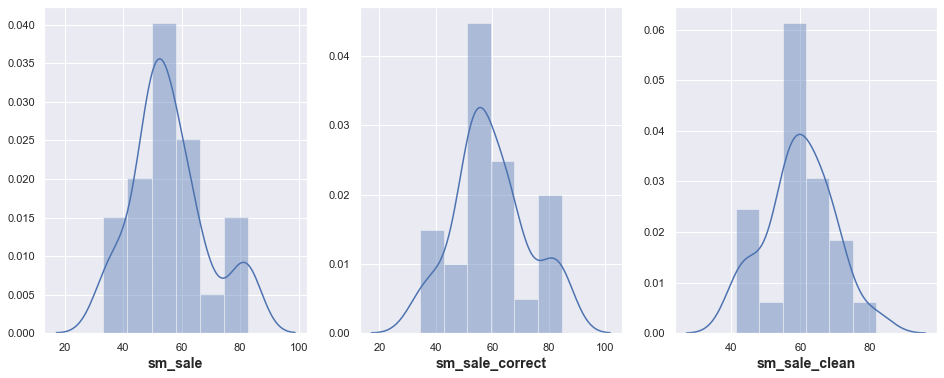

In [503]:
df_disp = df_data.groupby(['yr_number', 'period_id'], as_index = False).agg({
                                                                                'sm_sale':         'sum',
                                                                                'sm_sale_correct': 'sum',
                                                                                'sm_sale_clean':   'sum'
                                                                            })
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

plt.subplot(131)
g1 = sns.distplot(df_disp[['sm_sale']])
plt.xlabel('sm_sale', fontsize = 14, weight = 'bold')

plt.subplot(132)
g2 = sns.distplot(df_disp[['sm_sale_correct']])
plt.xlabel('sm_sale_correct', fontsize = 14, weight = 'bold')

plt.subplot(133)
g3 = sns.distplot(df_disp[['sm_sale_clean']])
plt.xlabel('sm_sale_clean', fontsize = 14, weight = 'bold')

plt.show()

### Еще один вид графика распредения общих продаж

### Продажи фактические, sm_sale

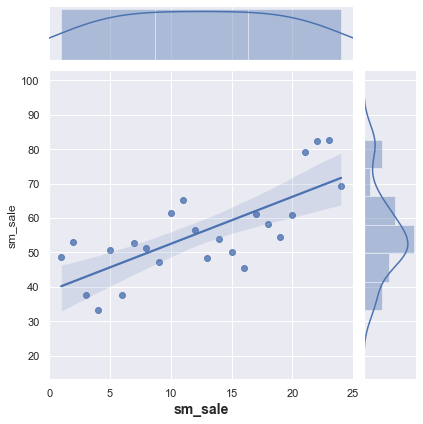

In [504]:
sns.jointplot(x='period_id', y='sm_sale', data=df_disp, kind='reg');
plt.xlabel('sm_sale', fontsize = 14, weight = 'bold')
plt.xlim(0, 25)
plt.show()

### Продажи очищенные, sm_sale_clean

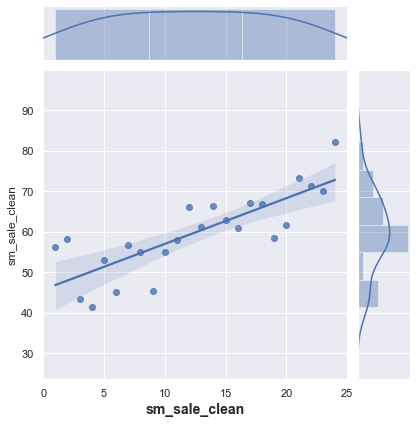

In [505]:
g1 = sns.jointplot(x='period_id', y='sm_sale_clean', data=df_disp, kind='reg');
plt.xlabel('sm_sale_clean', fontsize = 14, weight = 'bold')
plt.xlim(0, 25)
plt.show()

## Несколько графиков - Распредения продаж по товарным группам

### На примере Топ 10 товарных групп по обороту

In [506]:
df10 = df_groups_sales.loc[ df_groups_sales['product_group'].\
                           isin([
                                    'Дрель-шуруповерт аккумуляторная',
                                    'Машина шлифовальная угловая',
                                    'Перфоратор электрический',
                                    'Пылесос для сухой и влажной уборки',
                                    'Мойка высокого давления',
                                    'Измельчитель пищевых отходов',
                                    'Набор ручного инструмента'
                                ])]


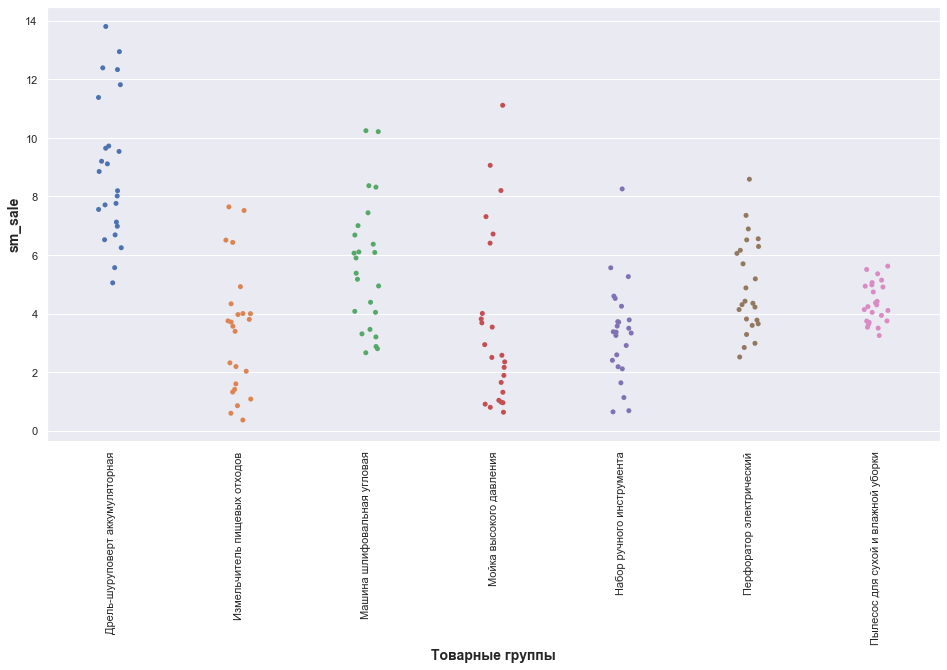

In [507]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

g = sns.stripplot(x = "product_group", y = "sm_sale", data = df10, jitter = True)
plt.xlabel('Товарные группы', fontsize = 14, weight = 'bold')
plt.ylabel('sm_sale', fontsize = 14, weight = 'bold')
plt.xticks(rotation = 90)
plt.show()

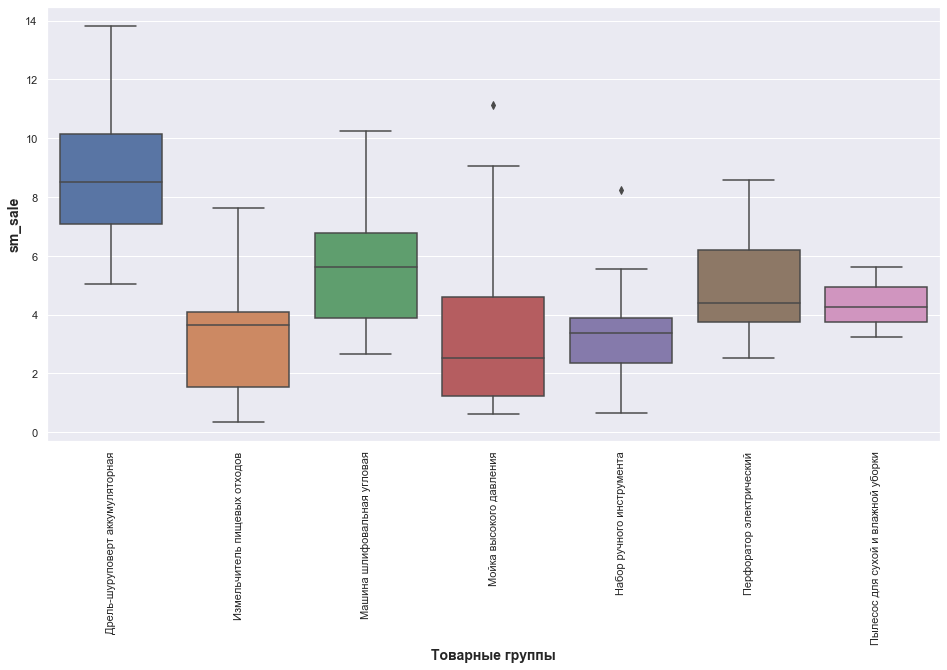

In [508]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

g = sns.boxplot(x = "product_group", y = "sm_sale", data = df10)
plt.xlabel('Товарные группы', fontsize = 14, weight = 'bold')
plt.ylabel('sm_sale', fontsize = 14, weight = 'bold')
plt.xticks(rotation = 90)
plt.show()

## Прогноз по товарам
### Подготовка основной таблицы

In [509]:
# Cross Join:  Все товары * Все периоды
df_forecast = df_data.groupby(['product_group', 'model', 'status_purchase'], as_index = False).\
                            agg({'sm_sale': 'sum'}).drop('sm_sale', axis = 1)
df_forecast = df_forecast.assign(temp = 1).merge(df_period.assign(temp = 1)).drop('temp', 1)
df_forecast.head(5)

# Данные по фактически продажам
df_forecast = df_forecast.merge(df_data[['model', 'period_id', 'sm_sale', 'sm_sale_correct', 'sm_sale_clean']],
                                on = ['model', 'period_id'], how = 'left')
df_forecast['x'] = df_forecast['period_id']
df_forecast['y'] = df_forecast['sm_sale_clean']

# Индексы сезонности
if not 'season_index' in df_forecast.columns:
    df_forecast = df_forecast.merge(df_season, on = ['product_group', 'mn'], how = 'left')

    # Для товарных групп, по которым не найдены данные по сезонности с Яндекса, применяю общую сезонность "Common"
    df_1 = df_season.loc[df_season['product_group'] == 'Common', ['mn', 'season_index']].\
                            rename(columns = {'season_index': 'season_index_common'})

    df_forecast = df_forecast.merge(df_1, on = ['mn'], how = 'left')
    df_forecast.loc[df_forecast['season_index'].isnull(), 'season_index'] = df_forecast['season_index_common']

print('Пример таблицы с данными для прогноза')
df_forecast.head(10)

Пример таблицы с данными для прогноза


,product_group,model,status_purchase,yr_number,yr,mn,yr_mn,period_id,flg_plan,sm_sale,sm_sale_correct,sm_sale_clean,x,y,season_index,season_index_common
0,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2018,10,2018-10,1,0,0.149421,0.149421,0.158638,1,0.158638,0.9419,1.04
1,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2018,11,2018-11,2,0,0.033714,0.033714,0.036275,2,0.036275,0.9294,1.04
2,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2018,12,2018-12,3,0,0.015363,0.090580,0.101650,3,0.101650,0.8911,0.96
3,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2019,1,2019-01,4,0,0.000000,0.000000,0.000000,4,0.000000,0.9761,0.72
4,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2019,2,2019-02,5,0,0.113777,0.113777,0.121466,5,0.121466,0.9367,0.84
5,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2019,3,2019-03,6,0,0.081622,0.081622,0.084086,6,0.084086,0.9707,0.96
6,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2019,4,2019-04,7,0,0.116683,0.116683,0.121229,7,0.121229,0.9625,0.99
7,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2019,5,2019-05,8,0,0.118022,0.118022,0.110632,8,0.110632,1.0668,1.07
8,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2019,6,2019-06,9,0,0.099506,0.099506,0.081898,9,0.081898,1.2150,1.23
9,Аппарат для сварки труб,BRS-1000,ДЕЙСТВУЕТ,1,2019,7,2019-07,10,0,0.137720,0.137720,0.132665,10,0.132665,1.0381,1.13


### Функция расчета коэффициентов линейной регрессии

In [510]:
def get_coef(x, y):
    
    b = (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(x**2) - np.mean(x) ** 2)
    a = np.mean(y) - b * np.mean(x)
    
    if (np.std(y) == 0):
        r = 0
    else:
        r = b * np.std(x) / np.std(y)
        
    R2 = r**2

    return [a, b, R2]

In [511]:
# перебор всех товаров
#   - поиск коэффициентов линейной регрессии
#   - расчет линии тренда
#   - расчет прогноза на следующий год
print('\033[1m\033[4mПервые 10 товаров:\n\033[0m')
count = df_products_stat.shape[0]
i = 0
for index, row in df_products_stat.iterrows():
    i += 1
    mdl = df_products_stat.loc[index, 'model']

    x = df_forecast.loc[ (df_forecast['model'] == mdl) & (df_forecast['flg_plan'] == 0), 'period_id']
    y = df_forecast.loc[ (df_forecast['model'] == mdl) & (df_forecast['flg_plan'] == 0), 'sm_sale_clean']

    list_coef = get_coef(x, y)

    a  = round(list_coef[0], 6)
    b  = round(list_coef[1], 6)
    R2 = round(list_coef[2], 6)

    # вывод первых 10-ти товаров
    if i <= 10:
        print(f'\033[1m{i}. {mdl}\n\ty = {round(a, 6)} + {round(b, 6)}*x;\tR2 = {round(R2, 6)}')
    elif i == 11:
        print('...')

    df_forecast.loc[ df_forecast['model'] == mdl, 'a'] = a
    df_forecast.loc[ df_forecast['model'] == mdl, 'b'] = b
    df_forecast.loc[ df_forecast['model'] == mdl, 'R2'] = R2
    df_forecast.loc[ df_forecast['model'] == mdl, 'sm_trend'] = df_forecast['a'] + df_forecast['b'] * df_forecast['period_id']

    df_forecast.loc[ (df_forecast['model'] == mdl) & (df_forecast['period_id'] == 24), 'sm_forecast'] = \
                    df_forecast['sm_sale']
    df_forecast.loc[ (df_forecast['model'] == mdl) & (df_forecast['flg_plan'] == 1), 'sm_forecast'] = \
                        df_forecast['sm_trend'] * df_forecast['season_index']
    
# обнуляю отрицательные значения прогноза и прогноз по товарам, выведенным из матрицы
df_forecast.loc[ df_forecast['sm_forecast'] < 0, 'sm_forecast'] = 0
df_forecast.loc[ df_forecast['status_purchase'] == 'ОТМЕНЕН', 'sm_forecast'] = 0

Первые 10 товаров:

1. BAB-18UX2LI-FDK
	y = 2.468123 + -0.065779*x;	R2 = 0.338962
2. BWS-905-R
	y = 1.202882 + 0.003832*x;	R2 = 0.006048
3. BHD-800N
	y = 1.359211 + -0.017305*x;	R2 = 0.043166
4. BTK-123
	y = 0.740449 + 0.035832*x;	R2 = 0.277545
5. BAB-12-P
	y = 1.000884 + 0.013038*x;	R2 = 0.028836
6. BHD-700-P
	y = 0.580692 + 0.035762*x;	R2 = 0.189348
7. BSS-1220-PRO
	y = 0.928048 + 0.011342*x;	R2 = 0.037204
8. BAB-14UX2LI-FDK
	y = 1.44498 + -0.041214*x;	R2 = 0.384382
9. TITAN MAX POWER
	y = 0.298152 + 0.039311*x;	R2 = 0.472808
10. BAB-10,8-P
	y = 1.196437 + -0.0343*x;	R2 = 0.540316
...


### Прогноз - Итоги по товарным группам

In [513]:
df_forecast_groups = df_forecast.groupby(['product_group', 'yr_number', 'yr_mn', 'period_id', 'flg_plan'], 
                                            as_index = False).agg(
                                        {
                                            'sm_sale':         'sum', 
                                            'sm_sale_correct': 'sum', 
                                            'sm_sale_clean':   'sum', 
                                            'sm_trend':        'sum',   
                                            'sm_forecast':     'sum'
                                        }
)
df_forecast_groups.loc[df_forecast_groups['flg_plan'] == 1, 'sm_sale'] = None
df_forecast_groups.loc[df_forecast_groups['flg_plan'] == 1, 'sm_sale_correct'] = None
df_forecast_groups.loc[df_forecast_groups['flg_plan'] == 1, 'sm_sale_clean'] = None

df_forecast_groups.loc[(df_forecast_groups['flg_plan'] == 0) & (df_forecast_groups['period_id'] != 24), 'sm_forecast'] = None

### Прогноз - Итог по всей компании

In [514]:
df_forecast_total = df_forecast.groupby(['yr_number', 'yr_mn', 'period_id', 'flg_plan'], as_index = False).agg(
    {
        'sm_sale':         'sum', 
        'sm_sale_correct': 'sum', 
        'sm_sale_clean':   'sum', 
        'sm_trend':        'sum',   
        'sm_forecast':     'sum',
        'season_index':    'mean'
    }
)
df_forecast_total['sm_trend_season'] = round(df_forecast_total['sm_trend'] / df_forecast_total['season_index'], 6)
df_forecast_total.loc[ df_forecast_total['flg_plan'] == 1, 'sm_sale'] = None
df_forecast_total.loc[ df_forecast_total['flg_plan'] == 1, 'sm_sale_correct'] = None
df_forecast_total.loc[ df_forecast_total['flg_plan'] == 1, 'sm_sale_clean'] = None

df_forecast_total.loc[ (df_forecast_total['flg_plan'] == 0) & (df_forecast_total['period_id'] != 24), 'sm_forecast'] = None
df_forecast_total.head(36)

,yr_number,yr_mn,period_id,flg_plan,sm_sale,sm_sale_correct,sm_sale_clean,sm_trend,sm_forecast,season_index,sm_trend_season
0,1,2018-10,1,0,48.543108,50.978933,56.158655,42.904155,NaN,0.932103,46.029399
1,1,2018-11,2,0,53.094500,51.893072,58.299882,44.925857,NaN,0.928305,48.395590
2,1,2018-12,3,0,37.721107,38.173512,43.429181,46.947559,NaN,0.907841,51.713393
3,1,2019-01,4,0,33.142238,34.382203,41.275306,48.969261,NaN,0.854648,57.297580
4,1,2019-02,5,0,50.660951,53.438512,53.072955,50.990963,NaN,0.998452,51.070019
5,1,2019-03,6,0,37.592245,42.664624,45.020384,53.012665,NaN,0.945619,56.061312
6,1,2019-04,7,0,52.646438,53.750761,56.707228,55.034367,NaN,0.923373,59.601430
7,1,2019-05,8,0,51.390530,56.618597,54.894800,57.056069,NaN,1.036015,55.072608
8,1,2019-06,9,0,47.199222,51.792355,45.451648,59.077771,NaN,1.142400,51.713735
9,1,2019-07,10,0,61.565291,65.242901,54.953657,61.099473,NaN,1.184268,51.592585


### Функция отрисовки графика Оборота (фактического, скорректированного, очищенного от сезонности, линии тренда и прогноза на следующий год)

In [515]:
def chart_sales_dynamics(a_type, a_filter = ''):

    example_model = ''
    example_group = ''

    if (a_type == 'product'):
        
        df_example    = df_forecast.loc[ df_forecast['model'] == a_filter.upper()]
        example_group = df_example['product_group'].unique()[0]
        example_model = df_example['model'].unique()[0]
        caption = 'Товар: '+ example_group + ' ' + example_model
        
    elif (a_type == 'group'):
        
        df_example = df_forecast_groups.loc[ df_forecast_groups['product_group'] == a_filter]
        caption = 'Товарная группа: ' + df_example['product_group'].unique()[0]
        
    else:

        df_example = df_forecast_total
        caption = 'Вся компания'
        
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 6)
    plt.xticks(rotation = 45)

    str_title = f'{caption}\nОборот по месяцам (млн руб):\nфактический, скорректированный и очищенный от сезонности,\
    линия тренда и прогноз на следующий год'
    plt.title(str_title, fontsize = 16, weight = 'bold')
    
    
    plt.xlabel('Месяцы',      fontsize = 12, weight = 'bold')
    plt.ylabel('Оборот, млн руб', fontsize = 12, weight = 'bold')

    plt.plot('yr_mn', 'sm_sale',         data = df_example, color = 'black',   linestyle = '-',  linewidth = 2)
    plt.plot('yr_mn', 'sm_sale_correct', data = df_example, color = 'hotpink', linestyle = '--', linewidth = 4)
    plt.plot('yr_mn', 'sm_sale_clean',   data = df_example, color = 'green',   linestyle = ':',  linewidth = 6)
    plt.plot('yr_mn', 'sm_trend',        data = df_example, color = 'red',     linestyle = '-',  linewidth = 2)
    plt.plot('yr_mn', 'sm_forecast',     data = df_example, color = 'blue',    linestyle = ':',  linewidth = 6)

    plt.legend()
    plt.show()

## Графики продаж на примере трех товаров (спад, рост, сильный рост продаж)

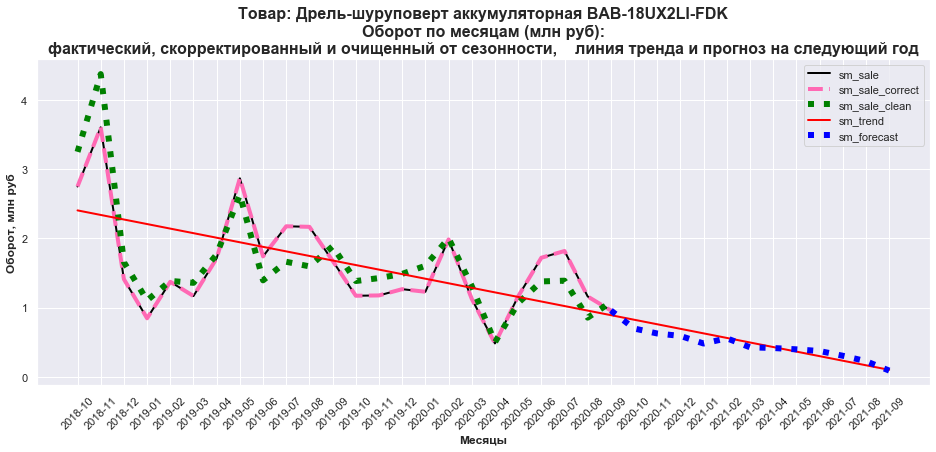

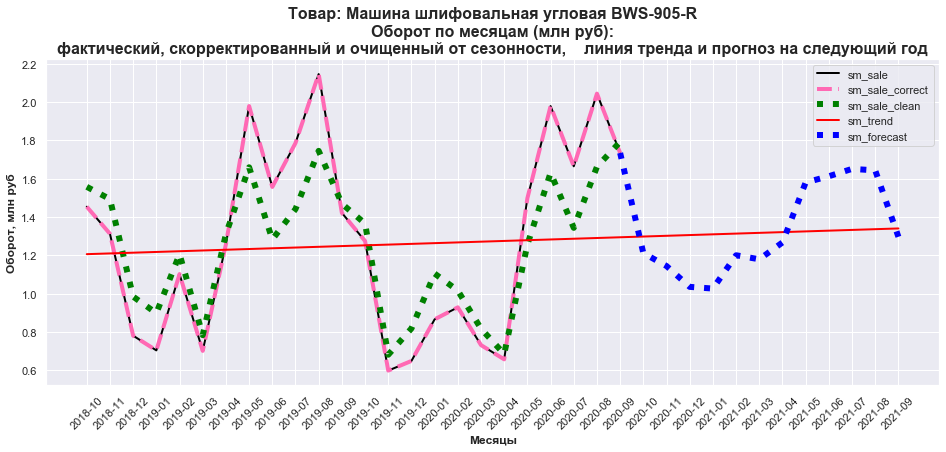

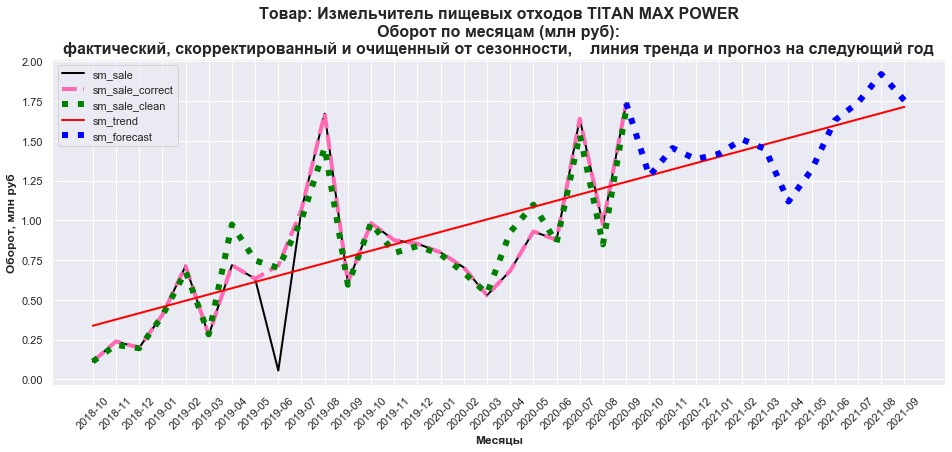

In [516]:
chart_sales_dynamics('product', 'BAB-18UX2LI-FDK')
chart_sales_dynamics('product', 'BWS-905-R')
chart_sales_dynamics('product', 'TITAN MAX POWER')

#'BHR-1900-PRO'
#'BSR-12H'
#'BHR-1600-SC'
#'BSS-550-R'
#'BLN-15-K'
#'COMPACT +'
#'BWS-905-R'
#'BAB-18UX2LI-FDK'
#'TITAN 4000 (CONTROL)'

## Графики продаж на примере трех трех товарных групп (спад, рост, сильный рост продаж)

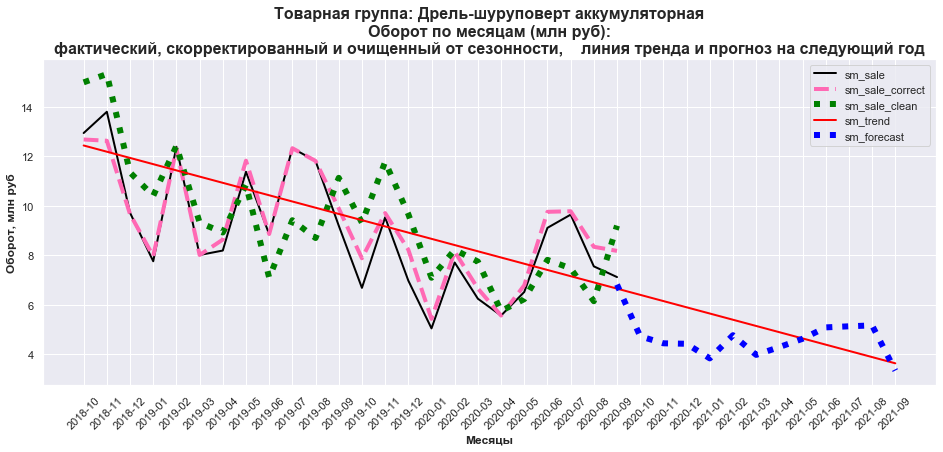

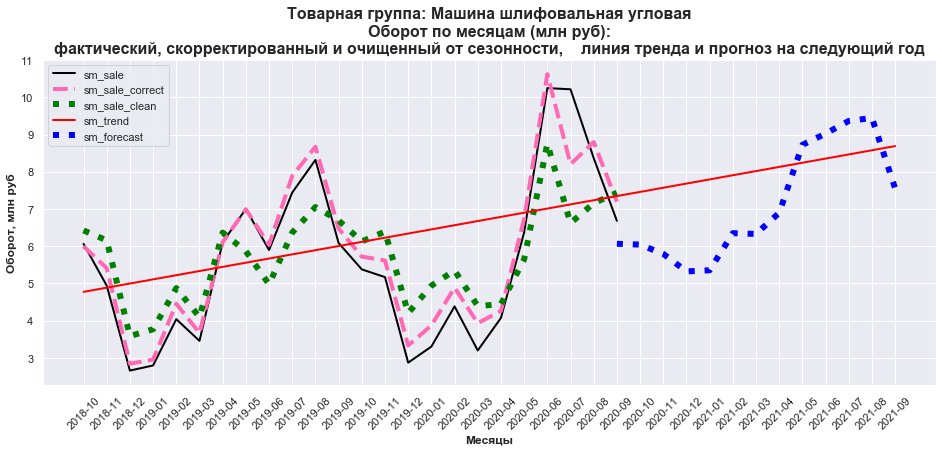

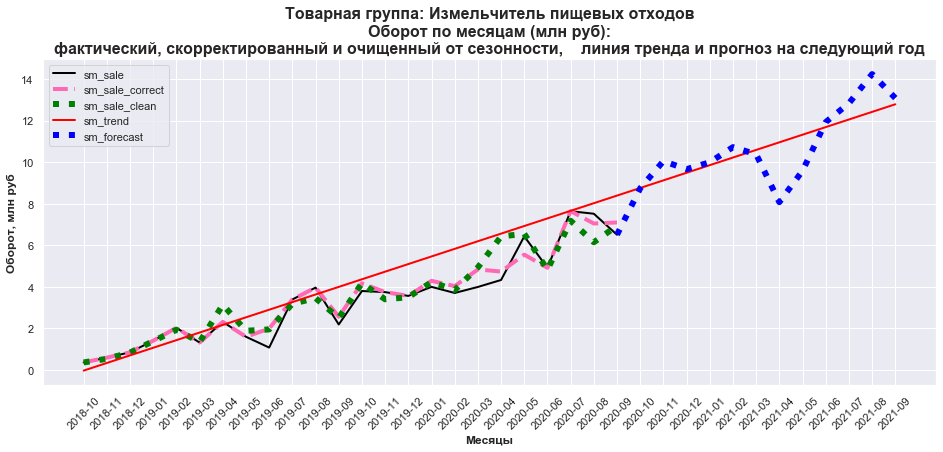

In [517]:
chart_sales_dynamics('group', 'Дрель-шуруповерт аккумуляторная')
chart_sales_dynamics('group', 'Машина шлифовальная угловая')
chart_sales_dynamics('group', 'Измельчитель пищевых отходов')

#'Дрель-шуруповерт аккумуляторная'
#'Машина шлифовальная угловая'
#'Гайковерт проводной автомобильный'
#'Мойка высокого давления'
#'Пылесос для сухой и влажной уборки'
#'Измельчитель пищевых отходов'
#'Набор ручного инструмента'

## График оборота и Основного прогноза по всей компании

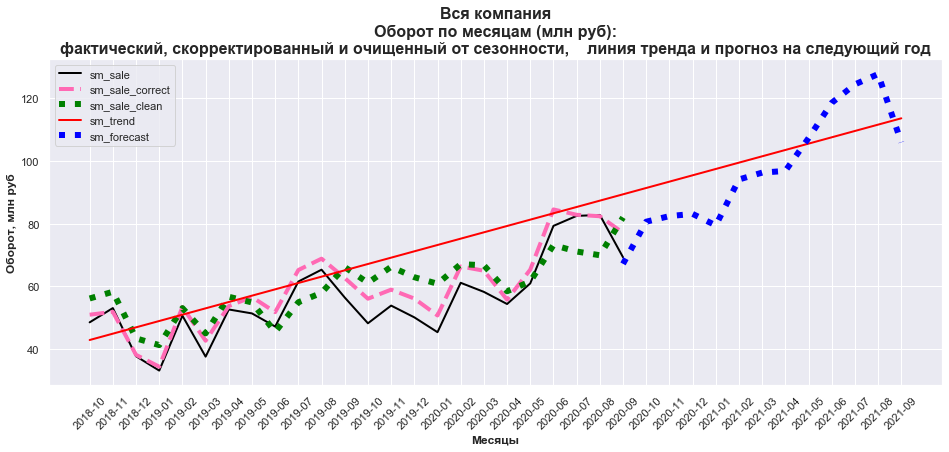

In [518]:
chart_sales_dynamics('company', '')

### Таблица - Общие итоги по годам (Оборот факт и Прогноз)

In [519]:
df_total_sm = df_forecast.groupby(['yr_number'], as_index = False).agg({
                                                                            'yr_mn':       ['min', 'max'],
                                                                            'sm_sale':     'sum', 
                                                                            'sm_forecast': 'sum'
                                                                        })

df_total_sm = df_total_sm.droplevel(1, axis=1)
df_total_sm.columns = ['yr_number', 'min_month', 'max_month', 'sm_sale', 'sm_forecast']
df_total_sm['period'] = df_total_sm['min_month'] + ' - ' + df_total_sm['max_month']

df_total_sm.loc[ df_total_sm['yr_number'] <= 2, 'sm_forecast'] = None
df_total_sm.loc[ df_total_sm['yr_number'] == 3, 'sm_sale']     = None

df_total_sm = df_total_sm[['yr_number', 'period', 'sm_sale', 'sm_forecast']]
df_total_sm

,yr_number,period,sm_sale,sm_forecast
0,1,2018-10 - 2019-09,595.364384,NaN
1,2,2019-10 - 2020-09,746.424948,NaN
2,3,2020-10 - 2021-09,NaN,1197.296465


### График - Общие итоги по годам (Оборот факт и Прогноз)

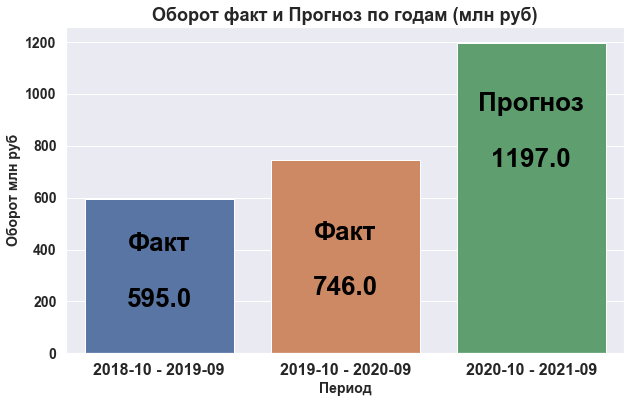

In [520]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

g1 = sns.barplot(x = 'period', y = 'sm_sale',     data = df_total_sm)
g2 = sns.barplot(x = 'period', y = 'sm_forecast', data = df_total_sm)

plt.xlabel('Период',     fontsize = 14, weight = 'bold')
plt.ylabel('Оборот млн руб', fontsize = 14, weight = 'bold')
plt.title(f'Оборот факт и Прогноз по годам (млн руб)', fontsize = 18, weight = 'bold')

plt.xticks(fontsize = 16, weight = 'bold')
plt.yticks(fontsize = 14, weight = 'bold')

for index, row in df_total_sm.iterrows():
    if index < 2:
        g1.text(row.name, row.sm_sale * 0.3, 'Факт\n\n' + str(round(row.sm_sale, 0)), 
               color = 'black', ha = "center", weight = 'bold', size = 26)

for index, row in df_total_sm.iterrows():
    if index > 1:
        g2.text(row.name, row.sm_forecast * 0.6, 'Прогноз\n\n' + str(round(row.sm_forecast, 0)), 
           color = 'black', ha = "center", weight = 'bold', size = 26)
plt.show()

## Общие выводы и оценка модели 

### Оценка трех моделей, построенных на показателях: sm_sale, sm_sale_correct, sm_sale_clean

In [521]:
s = '\033[1m'
print()
x = np.arange(1, 25)

y = df_forecast_total.loc[df_forecast_total['sm_sale'].notnull(), 'sm_sale']
res = get_coef(x, y)
print(f'{s}Модель на показателе sm_sale:         y = {round(res[0], 6)}  + {round(res[1], 6)}  * x;\t R2 = {round(res[2], 6)}')

y = df_forecast_total.loc[df_forecast_total['sm_sale'].notnull(), 'sm_sale_correct']
res = get_coef(x, y)
print(f'{s}Модель на показателе sm_sale_correct: y = {round(res[0], 6)} + {round(res[1], 6)} * x;\t R2 = {round(res[2], 6)}')

y = df_forecast_total.loc[df_forecast_total['sm_sale'].notnull(), 'sm_sale_clean']
res = get_coef(x, y)
print(f'{s}Модель на показателе sm_sale_clean:   y = {round(res[0], 6)} + {round(res[1], 6)} * x;\t R2 = {round(res[2], 6)}')


Модель на показателе sm_sale:         y = 38.79589  + 1.36896  * x;	 R2 = 0.548305
Модель на показателе sm_sale_correct: y = 41.095629 + 1.485396 * x;	 R2 = 0.633812
Модель на показателе sm_sale_clean:   y = 45.658735 + 1.130084 * x;	 R2 = 0.648724


### В целом линейная модель достаточно грубая 
1. Так на исходных, не очищенных данных, для модели, построенной на показателе **sm_sale**, коэффициент детерминации:  
**R2 = 0.548**  


2. С помощью корректировки "плохих" данных (отсутствия товара на складе и резких выбросов), модель, построенная на показателе **sm_sale_correct** оказалась лучше и ее коэффициент детерминации:  
**R2 = 0.634**  


3. После дальнейшей очистки данных от коэффициентов сезонности, модель на показателе **sm_sale_clean** была еще немного улучшена до   
**R2 = 0.648**



### Но если углубляться до конкретных товаров, то разброс значений коэффициента R2 получился достаточно большой

In [522]:
cnt_les_30  = df_forecast.loc[ df_forecast['R2'] < 0.3,  'model'].nunique()
cnt_les_50  = df_forecast.loc[ df_forecast['R2'] < 0.5,  'model'].nunique()
cnt_more_50 = df_forecast.loc[ df_forecast['R2'] >= 0.5, 'model'].nunique()
cnt_more_70 = df_forecast.loc[ df_forecast['R2'] >= 0.7, 'model'].nunique()
cnt_more_90 = df_forecast.loc[ df_forecast['R2'] >= 0.9, 'model'].nunique()

In [523]:
cnt_total = 273
print(f'{s}Так из {cnt_total}-х товаров')
print(f'{s}\tR2 меньше 0.3 у {cnt_les_30} товаров {int(cnt_les_30 / cnt_total * 100)}%')
print(f'{s}\tR2 меньше 0.5 у {cnt_les_50} товаров {int(cnt_les_50 / cnt_total * 100)}%')
print(f'{s}\tR2 больше 0.5 у  {cnt_more_50} товаров {int(cnt_more_50 / cnt_total * 100)}%')
print(f'{s}\tR2 больше 0.7 у  {cnt_more_70} товаров {int(cnt_more_70 / cnt_total * 100)}%')
print(f'{s}\tR2 больше 0.9 у  {cnt_more_90} товаров {int(cnt_more_90 / cnt_total * 100)}%')


Так из 273-х товаров
	R2 меньше 0.3 у 154 товаров 56%
	R2 меньше 0.5 у 199 товаров 72%
	R2 больше 0.5 у  74 товаров 27%
	R2 больше 0.7 у  64 товаров 23%
	R2 больше 0.9 у  61 товаров 22%


### Оценка качества модели с помощью средней ошибки аппроксимации

In [524]:
y = df_forecast_total.loc[df_forecast_total['sm_sale'].notnull(), 'sm_sale_clean']
y_pred = df_forecast_total.loc[df_forecast_total['sm_sale'].notnull(), 'sm_trend']
A_mean = round(100 * np.mean(np.abs((y - y_pred) / y)), 2)

print(f'{s}Средняя ошибка апроксимации A(ср) = {A_mean}%')

Средняя ошибка апроксимации A(ср) = 15.19%


Средняя ошибка апроксимации A(ср) = 15.19%.  
Это несколько хуже общепринятых значений для хорошей модели 8-10%.  
Но, в целом, такое отклонение является не критичным.

### Для оценки значимости уравнения регрессии вычисляею F-критерий Фишера, фактическое значение  𝐹-критерия (𝐹факт):

In [525]:
n = len(x)
R2 = res[2]
F_fact = (R2 * (n - 2)) / (1 - R2)
print(f'{s}\tКритерий Фишера F(fact) = {round(F_fact, 2)}')
print(f'{s}\tКритерий Фишера F(теор) = 4.30')
print(f'{s}\t{round(F_fact, 2)} > 4.30 => уравнение регрессии статистически значимо')

	Критерий Фишера F(fact) = 40.63
	Критерий Фишера F(теор) = 4.30
	40.63 > 4.30 => уравнение регрессии статистически значимо


#### Определяю стандартную ошибку (s_residual) и случайные ошибки 𝑚𝑎, 𝑚𝑏

In [526]:
s_residual = np.sqrt(np.sum((y - y_pred)**2) / (n - 2))
m_a = s_residual * np.sqrt(np.sum(x ** 2)) / (n * np.std(x))
m_b = s_residual / (np.std(x) * np.sqrt(n))

print(f'{s}Стандартная и случайные ошибки:')
print(f'{s}\ts_residual = {round(s_residual, 6)}\n\tm_a = {round(m_a, 6)}\n\tm_b = {round(m_b, 6)}')

Стандартная и случайные ошибки:
	s_residual = 11.043327
	m_a = 4.653111
	m_b = 0.32565


### Вычиcляю наблюдаемые значения критерия 𝑡𝑎  и  𝑡𝑏 

In [527]:
a = res[0]
b = res[1]

t_a = a / m_a
t_b = b / m_b

print(f'{s}Наблюдаемые значения критерия 𝑡𝑎 и 𝑡𝑏:')
print(f'{s}\t t_a = {round(t_a, 6)}')
print(f'{s}\t t_b = {round(t_b, 6)}')

Наблюдаемые значения критерия 𝑡𝑎 и 𝑡𝑏:
	 t_a = 9.812518
	 t_b = 3.470241


Фактические значения t-статистики больше табличного значения:  

* 𝑡𝑎 = 8.8807 > 𝑡кр=2.074, 𝑡𝑏 = 3.1407 > 𝑡кр = 2.074,  
* поэтому параметры 𝑎 и 𝑏 не случайно отличаются от нуля,   
* то есть они статистически значимы.  

### Считаю доверительные интервалы для параметров регрессии  𝑎  и  𝑏 . 

In [528]:
t_cr = 2.074

delta_a = t_cr * m_a
delta_b = t_cr * m_b

gamma_a_min = a - delta_a
gamma_a_max = a + delta_a

gamma_b_min = b - delta_b
gamma_b_max = b + delta_b

print(f'{s}Модель:   y = {round(res[0], 6)} + {round(res[1], 6)} * x;\t R2 = {round(res[2], 6)}')
print(f'{s}Доверительные интервалы для параметров регрессии:')
print(f'{s}\tдля a: [{round(gamma_a_min, 6)}, {round(gamma_a_max, 6)}]')
print(f'{s}\tдля b: [{round(gamma_b_min, 6)}, {round(gamma_b_max, 6)}]')

Модель:   y = 45.658735 + 1.130084 * x;	 R2 = 0.648724
Доверительные интервалы для параметров регрессии:
	для a: [36.008182, 55.309287]
	для b: [0.454686, 1.805482]
